In [1]:
using LinearAlgebra                                                             
using Test                                                                                       
using Distributions                                                             
using DataFrames                                                                          
using CSV                                                                              
using Polynomials  
using Roots
using Plots
using StatsFuns
                                                                                 
include("../computation/finitedifference.jl")                                                   
include("../quadrature/quadrature.jl")                                             
include("../transforms/transforms.jl")                                             
include("../priors/priors.jl")                                                     
include("../bayesopt/incremental.jl")                                              
include("../kernels/kernel.jl")                                                    
include("../datastructs.jl")                                                       
include("../computation/buffers0.jl") #datastruct, kernel, incremental, quadrature 
include("../model0.jl") #buffers, datastructs, several auxiliary                   
include("../computation/tdist.jl") #model0 and buffer0  

comp_tdist

In [2]:
function covariate_fun(x, p)
    n = size(x, 1)
    d = size(x, 2)
    if p == 1
        return ones(n, 1)
    elseif p == 1 + d
        return hcat(ones(n), x)
    else
         throw(ArgumentError("Only support constant or linear convariate."))
    end
end

covariate_fun (generic function with 1 method)

In [3]:
# Data and setup for different tests

# choice of covariate functions
p = 1
p = 2

# training
x1 = [0., .5, .8, 1., 1.6, 2.]
x2 = [0., .5, .8, 1., 2.]
x3 = [0., .8, 1., 1.6, 2.]
x4 = [0., 1., 1.6, 2.]

# testing
x01 = .25
x02 = 1.2
x03 = .5
x04 = .6

# underlying 1d function
test_fun1(x) = sin(x) + 1.1
test_fun2(x) = sin(15*x) + (x^2+1) 
test_fun3(x) = log(x^2+1) + (x^3+x+1)/(exp(x)) 

test_fun3 (generic function with 1 method)

# Summary
**Settings parameters**: \
p: choices of covariates, p = 1 if constant and p = 2 if linear \
x: training data \
x0: testing data
test_fun: underlying function

**Tests**:
1. p=1 or p=2, x=x1, x0=x01, test_fun=test_fun1 \
    narrow pdf, some quantile comp hard ==> bracketing interval $[0,5]$ works well!
2. p=1, x2, x02, test_fun2 \
    pdf very large near 0, so 2.5% quantile estimation gives negative estimate, which is not a good guess and also indicates that 2.5% quantile is extremely small. 
3. p=1, x3, x03, test_fun3 \
    narrow pdf, median hard ==> bracketing interval $[0,5]$ works well! \
    cdf(0) = 0.02898, 2.5% quantile doesn't exist
4. p=1, x4, x04, test_fun1 \
    two-peak pdf, can do mode, some quantile, but two-peak makes computation of CI (equal and narrow) super hard.
    
**Conclusion**:
1. Narrow pdf is the hardest case. Even if quant0 provides relatively good initial guess, find_zero easily goes to negative region, where CDF is not defined. \
Solution: bracketing interval works better than initial guess in root-finding
2. cdf(0) > 2.5% makes 2.5% quantile doesn't exist          
3. Weird shape: large pdf near 0 and two-peak pdf should be carefully treated. 
 

In [7]:
p = 1 # choose covariate basis function, only support 1 or 1+dim(x)
x = x3 # choose training data 
x0 = x03 # choose testing data
test_fun = test_fun1 # choose underlying function

x = reshape(x, size(x, 1), 1)
x0 = reshape([x0], 1, 1) 
Fx = covariate_fun(x, p)
y = reshape(test_fun.(x), size(x, 1))
ymax = maximum(y)
y /= ymax
trainingData1 = trainingData(x, Fx, y) 

Fx0 = covariate_fun(x0, p)
y0_true = reshape(test_fun.(x0), 1)./ymax
println("Prediction at x0 = $x0")
println("Covariates at x0: $Fx0")
println("Should expect peak near $y0_true")

Prediction at x0 = [0.5]
Covariates at x0: [1.0]
Should expect peak near [0.752260142876725]


In [8]:
d = getDimension(trainingData1)
n = getNumPts(trainingData1)
p = getCovDimension(trainingData1)
rangeθ = [0.25 100]
rangeλ = [0.5 5]

btg1 = btg(trainingData1, rangeθ, rangeλ)
pdf, cdf, dpdf, quantInfo = solve(btg1);

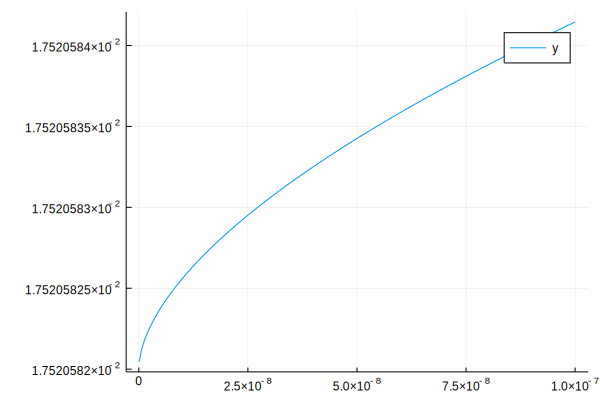

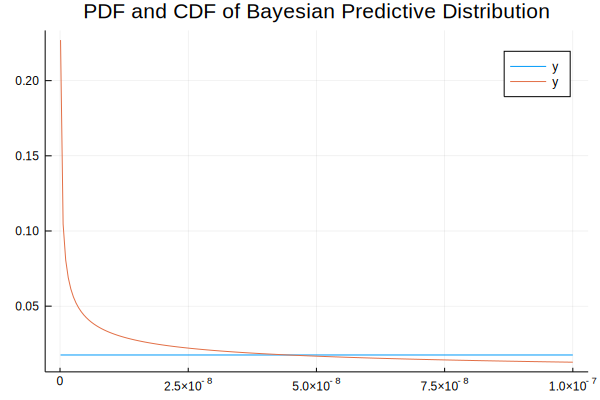

([1.0e-10, 6.020100502512562e-10, 1.1040201005025125e-9, 1.6060301507537689e-9, 2.108040201005025e-9, 2.610050251256281e-9, 3.1120603015075377e-9, 3.614070351758794e-9, 4.11608040201005e-9, 4.618090452261306e-9  …  9.548190954773868e-8, 9.598391959798994e-8, 9.64859296482412e-8, 9.698793969849244e-8, 9.74899497487437e-8, 9.799195979899496e-8, 9.849396984924622e-8, 9.899597989949748e-8, 9.949798994974872e-8, 9.999999999999998e-8], [0.22698468616642592, 0.10458917305091892, 0.08076369940524247, 0.06890226783944066, 0.06142983032709076, 0.05615035076348846, 0.052155324760390344, 0.048990480535379896, 0.04639962503513789, 0.044225630588736284  …  0.012947576275003926, 0.01292094461246086, 0.0128945097033463, 0.012868269077943306, 0.012842220310137976, 0.012816361016429575, 0.012790688854968063, 0.01276520152461819, 0.012739896764049113, 0.012714772350849064])

In [23]:
# Plot to see the shape of pdf and cdf
dpdf_fixed = y0 -> dpdf(x0, Fx0, y0) 
pdf_fixed = y0 -> pdf(x0, Fx0, y0)
cdf_fixed = y0 -> cdf(x0, Fx0, y0)
a = 1e-10; b = 1e-7
plt(cdf_fixed, a, b, 200)
# plt!(dpdf_fixed, a, b, 200)
plt!(pdf_fixed, a, b, 200, title = "PDF and CDF of Bayesian Predictive Distribution")

# Quantile computation

In [26]:
include("test_quantile.jl")
include("../statistics.jl")

credible_interval (generic function with 3 methods)

In [27]:
# preprocess output from solve(btg)
pdf_fixed, cdf_fixed, quant0, support = pre_process(x0, Fx0, pdf, cdf, quantInfo[1]);
println("Estimated support of pdf: $support")

Estimated support of pdf: [0.001, 5.0]


In [28]:
px = 0.5
quant_px = quantile(pdf_fixed, cdf_fixed, quant0, support; p=px)
# quant_0 = Roots.fzero(y-> cdf_fixed(y) - 0.5, 0, 5)

(0.7520702510511227, 9.547918011776346e-15)

In [29]:
med = median(pdf_fixed, cdf_fixed, quant0, support)

(0.7520702510511227, 9.547918011776346e-15)

In [30]:
mod = mode(pdf_fixed, cdf_fixed, support)

0.7516625543907569

In [31]:
confidence_level = .95
CI_equal = credible_interval(pdf_fixed, cdf_fixed, quant0, support; 
    mode=:equal, wp = confidence_level)

([0.4597959620802875, 1.0499030392881563], 0.0)

In [32]:
CI_narrow = credible_interval(pdf_fixed, cdf_fixed, quant0, support;
    mode=:narrow, wp = confidence_level)

([0.570707309162015, 1.1022344441414724], 5.3370437893668645e-9)